# Belief in Supernatural Evil and Guns Assignment


In this assignment we will discuss the belief in supernatural evil and the attitudes toward gun policy in the United States. 


---

> Dimitris Mazarakis, Student <br />
> AM: 8180064  <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> t8180064@aueb.gr

In [2984]:
import numpy as np

import glob
import re
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats.stats as stats

from sklearn.decomposition import PCA


Here we read the csv file and save it to the first_data_with_nans table.

In [2985]:
data_filename = "data/Baylor Religion Survey, Wave IV (2014) - Instructional Dataset.csv"

first_data_with_nans = pd.read_csv(data_filename, sep=";")

# Q1

Firstly, we find the total points given to the three questions and after that we find how many 
answers did the candidate answered.
Then we calcutate the average for the three metrics and save it to one metric.

In [2986]:
total_points = first_data_with_nans['Q23C'] + first_data_with_nans['Q23A'] + first_data_with_nans['Q23G']
answers = first_data_with_nans['Q23C'].notna()*1 + first_data_with_nans['Q23A'].notna()*1 + first_data_with_nans['Q23G'].notna()*1

useful_vars = pd.DataFrame() 

first_data_with_nans['Evil'] = round(total_points/answers)

first_data_with_nans['Evil'].mean()

3.090909090909091

We can see that by running PCA on the data (the three columns that we need) we get that by using only one metric instead of the three we can explain the 0.901 of the variance. Also the loads for each metric is close to 0.5 so each metric affects the model almost the same amount.

In [2987]:
from sklearn.preprocessing import StandardScaler

copy_data = first_data_with_nans[~first_data_with_nans[['Q23C','Q23A','Q23G']].isin([np.nan, np.inf, -np.inf]).any(1)]
X = copy_data[['Q23C','Q23A','Q23G']]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pca = PCA(n_components=1)
X_proj = pca.fit(X).transform(X)
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
print("Loads", pca.components_)

Explained variance ratio: [0.90169696]
Loads [[-0.57618441 -0.58613485 -0.56961168]]


# Q2

Creating new dataset with only the columns we need.

In [2988]:
first_data = first_data_with_nans[['Evil','Q73A','Q73E','Q73G','Q73H','Q73C','Q73F','Q73B'
                         ,'Q73D','Q4','AGE','Q17','RELTRAD','Q31','Q77'
                         ,'Q88A','Q89','Q88B','Q88C','Q88D','Q88E','Q88F'
                         ,'I_EDUC','Q95','Q51A','Q93','Q80']]

Imputing the data using miceforest library.

In [2989]:
import miceforest as mf

data_amp = mf.ampute_data(first_data,random_state=50)

# Create kernel. 
kds = mf.ImputationKernel(
  data_amp,
  datasets=1,
  save_all_iterations=True,
  random_state=50
)

kds.mice(1)


In [2990]:
first_data = kds.complete_data(dataset=0, inplace=False)

Coding Dependent Variables

In [2992]:
useful_vars['Evil'] = first_data['Evil']

In [2993]:
useful_vars['Semi_auto'] = np.where((first_data['Q73A'] == 1) ,True,False)*1
useful_vars['High_cap'] = np.where((first_data['Q73E'] == 1) ,True,False)*1
useful_vars['Handguns'] = np.where((first_data['Q73G'] == 1) ,True,False)*1
useful_vars['Concealed'] = np.where((first_data['Q73H'] == 1) ,True,False)*1
useful_vars['Armed_schools'] = np.where((first_data['Q73C'] == 1) ,True,False)*1
useful_vars['Armed_teachers'] = np.where((first_data['Q73F'] == 1) ,True,False)*1
useful_vars['Safety_prog'] = np.where((first_data['Q73B'] == 1) ,True,False)*1
useful_vars['Mental_Health_Screening'] = np.where((first_data['Q73D'] == 1) ,True,False)*1

In [2994]:
useful_vars['Attendance'] = first_data['Q4']
useful_vars['Age'] = first_data['AGE']

Coding Religious Variables

In [2995]:
useful_vars['Literalism'] = np.where((first_data['Q17'] == 1) ,True,False)*1
useful_vars['Inerrancy'] = np.where((first_data['Q17'] == 2) ,True,False)*1
useful_vars['Human_error_legends'] = np.where(((first_data['Q17'] == 3) | (first_data['Q17'] == 4)) ,True,False)*1
useful_vars['Inerrancy'].mean()

0.3746819338422392

Coding Religious Affiliation Variables

In [2996]:
useful_vars['Conservative_Protestant'] = np.where((first_data['RELTRAD'] == 1) ,True,False)*1
useful_vars['Mainline_Protestant'] = np.where((first_data['RELTRAD'] == 2) ,True,False)*1
useful_vars['Black_Protestant'] = np.where((first_data['RELTRAD'] == 3) ,True,False)*1
useful_vars['Catholic'] = np.where((first_data['RELTRAD'] == 4) ,True,False)*1
useful_vars['Other_religion'] = np.where(((first_data['RELTRAD'] == 6) | (first_data['RELTRAD'] == 5)) ,True,False)*1
useful_vars['No_Affiliation'] = np.where((first_data['RELTRAD'] == 7) ,True,False)*1

Coding Political Ideology Variables

In [2997]:
useful_vars['Political_Ideology'] = first_data['Q31']

Coding Sex Variables

In [2998]:
useful_vars['Female'] = np.where((first_data['Q77'] == 2) ,True,False)*1
useful_vars['Male'] = np.where((first_data['Q77'] == 1) ,True,False)*1

Coding Race Variables

In [2999]:
useful_vars['White'] = np.where((first_data['Q88A'] == 1) ,True,False)*1
useful_vars['Hispanic'] = np.where((first_data['Q89'].notna()) & (first_data['Q89'] != 1) ,True,False)*1
useful_vars['African_American_Black'] = np.where((first_data['Q88B'] == 1) ,True,False)*1
useful_vars['Non_Hispanic'] = np.where((first_data['Q89'] == 1) ,True,False)*1
useful_vars['Non_Hispanic_Black'] = np.where((useful_vars['Non_Hispanic'] == 1) & (useful_vars['African_American_Black'] == 1) ,True,False)*1
useful_vars['Other_region'] = np.where(((first_data['Q88C'] == 1)) | ((first_data['Q88D'] == 1)) | ((first_data['Q88E'] == 1)) | ((first_data['Q88F'] == 1)),True,False)*1
useful_vars['African_American_Black'].mean()

0.1628498727735369

Coding Education Variables

In [3000]:
useful_vars['Less'] = np.where((first_data['I_EDUC'] == 1) ,True,False)*1
useful_vars['High'] = np.where((first_data['I_EDUC'] == 2) ,True,False)*1
useful_vars['Some_Collage'] = np.where((first_data['I_EDUC'] == 3) ,True,False)*1
useful_vars['College_Degree'] = np.where((first_data['I_EDUC'] == 5) ,True,False)*1
useful_vars['Post_graduat_Degree'] = np.where((first_data['I_EDUC'] == 6) ,True,False)*1

Coding Income and Status Variables

In [3001]:
useful_vars['Income'] = first_data['Q95']

In [3002]:
useful_vars['Married_Cohabitating'] = np.where((first_data['Q51A'] == 2) | ((first_data['Q51A'] == 3)),True,False)*1
useful_vars['Not_Partnered_Single_Other'] = np.where((first_data['Q51A'] == 1) | (first_data['Q51A'] == 4) | (first_data['Q51A'] == 5) | (first_data['Q51A'] == 6) ,True,False)*1

Coding Children Variables

In [3003]:
useful_vars['Child_under_18'] = np.where((first_data['Q93'] >= 1),True,False)*1

Coding Area Demographics Variables

In [3004]:
useful_vars['Urban'] = np.where((first_data['Q80'] == 1) | (first_data['Q80'] == 2) ,True,False)*1

Finding if the candidate lives in a South state in the U.S.A.

In [3005]:
southern_states =  ["AL", "AR", "DE", "FL", "GA", "KY", "LA", "MD", "MS", "NC", "OK", "SC", "TN", "TX", "VA", "WV"]

In [3006]:
useful_vars['South'] = np.where(first_data_with_nans['STATE'].isin(southern_states) ,True,False)*1

# Q3

### Model 1
Model for Semi-Auto Weapons Ban and Religious Variables

In [3007]:
from statsmodels.formula.api import logit

mod = logit("Semi_auto ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion", data=useful_vars)
res = mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.644973
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.019     
Dependent Variable:   Semi_auto          AIC:                2047.7959 
Date:                 2021-12-19 17:59   BIC:                2101.3970 
No. Observations:     1572               Log-Likelihood:     -1013.9   
Df Model:             9                  LL-Null:            -1033.4   
Df Residuals:         1562               LLR p-value:        1.1699e-05
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       5.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept                1.1884   0.1940  6.1270 0.0000  0.8082  1.5686
Evil                    -0.3232   0.0776 -4.1672 0.0000 -0.4753 -0.1712
Attendance               0.0470   0.0241  1.9518 0.0510 -0.0002  0.0942
Literalism               0.0795   0.1980  0.4015 0.6881 -0.3086  0.4676
Inerrancy                0.0645   0.1617  0.3987 0.6901 -0.2525  0.3815
Mainline_Protestant      0.1152   0.2214  0.5201 0.6030 -0.3188  0.5492
Black_Protestant         0.4847   0.2877  1.6848 0.0920 -0.0792  1.0485
Conservative_Protestant -0.0443   0.2391 -0.1852 0.8531 -0.5130  0.4244
Catholic                 0.2623   0.2080  1.2612 0.2073 -0.1454  0.6700
Other_religion           0.4883   0.2536  1.9252 0.0542 -0.0088  0.9854
=======================================================================

"""

Converting Coef to percents.

In [3008]:
for index, row in res.summary2().tables[1]['Coef.'][1:].iteritems() :
    print(index, math.exp(row))

Evil 0.7238051685421683
Attendance 1.0480971400816597
Literalism 1.0827524763912963
Inerrancy 1.0666005540620793
Mainline_Protestant 1.1220736527074864
Black_Protestant 1.623641890497663
Conservative_Protestant 0.9566757555045325
Catholic 1.2999419064442168
Other_religion 1.629499482248457


### Model 2
Model for Semi-Auto Weapons Ban, Religious and Political Variables

In [3009]:
mod = logit("Semi_auto ~ Evil + Attendance + Inerrancy + Literalism"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Non_Hispanic_Black"
            "+ Hispanic + Other_region + Female + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars)
res = mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.534105
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.188     
Dependent Variable:   Semi_auto          AIC:                1729.2248 
Date:                 2021-12-19 17:59   BIC:                1863.2273 
No. Observations:     1572               Log-Likelihood:     -839.61   
Df Model:             24                 LL-Null:            -1033.4   
Df Residuals:         1547               LLR p-value:        2.7052e-67
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               -2.6776   0.4950 -5.4097 0.0000 -3.6478 -1.7075
Evil                    -0.2150   0.0914 -2.3519 0.0187 -0.3941 -0.0358
Attendance               0.0772   0.0287  2.6900 0.0071  0.0209  0.1334
Inerrancy                0.1077   0.1858  0.5796 0.5622 -0.2565  0.4719
Literalism               0.2804   0.2279  1.2305 0.2185 -0.1662  0.7271
Mainline_Protestant      0.3182   0.2547  1.2495 0.2115 -0.1809  0.8173
Black_Protestant         0.2986   0.3467  0.8613 0.3891 -0.3809  0.9780
Conservative_Protestant  0.3768   0.2728  1.3816 0.1671 -0.1578  0.9114
Catholic                 0.4613   0.2390  1.9303 0.0536 -0.0071  0.9297
Other_religion           0.4148   0.2919  1.4210 0.1553 -0.1573  0.9868
Political_Ideology       0.5547   0.0512 10.8390 0.0000  0.4544  0.6551
Non_Hispanic_Black       0.1943   0.2289  0.8489 0.3959 -0.2544  0.6430
Hispanic                 0.2560   0.1817  1.4091 0.1588 -0.1001  0.6121
Other_region            -0.1573   0.2023 -0.7775 0.4369 -0.5537  0.2392
Female                   1.1782   0.1280  9.2041 0.0000  0.9273  1.4291
Less                    -0.5126   0.2821 -1.8171 0.0692 -1.0655  0.0403
Some_Collage            -0.2410   0.1740 -1.3849 0.1661 -0.5820  0.1001
College_Degree          -0.2482   0.1823 -1.3618 0.1733 -0.6054  0.1090
Post_graduat_Degree      0.2126   0.2094  1.0157 0.3098 -0.1977  0.6230
Age                      0.0133   0.0033  4.0092 0.0001  0.0068  0.0197
Income                   0.0634   0.0457  1.3877 0.1652 -0.0261  0.1529
Married_Cohabitating    -0.2015   0.1356 -1.4858 0.1373 -0.4672  0.0643
Child_under_18          -0.3713   0.1460 -2.5424 0.0110 -0.6575 -0.0851
Urban                    0.3733   0.1252  2.9805 0.0029  0.1278  0.6188
South                   -0.4177   0.1253 -3.3323 0.0009 -0.6634 -0.1720
=======================================================================

"""

In [3010]:
for index, row in res.summary2().tables[1]['Coef.'][1:].iteritems() :
    print(index, math.exp(row))

Evil 0.8065737005963358
Attendance 1.0802172119691986
Inerrancy 1.1137118163443362
Literalism 1.3237141684330282
Mainline_Protestant 1.3746320513049828
Black_Protestant 1.3479625072984016
Conservative_Protestant 1.457678619695547
Catholic 1.5861105886725329
Other_religion 1.5139992122609096
Political_Ideology 1.7414908219098648
Non_Hispanic_Black 1.214498492891094
Hispanic 1.2917732109146502
Other_region 0.8544721130797182
Female 3.2486601541900852
Less 0.5989351390454867
Some_Collage 0.7858468286101361
College_Degree 0.7802042967756
Post_graduat_Degree 1.2369275600995961
Age 1.013349425041447
Income 1.0654115655299814
Married_Cohabitating 0.8175246576008645
Child_under_18 0.6898675108455686
Urban 1.4524955777251969
South 0.6585617977642839


### Model 3
Model for High-Capacity Magazine Ban and Religious Variables

In [3011]:
mod = logit("High_cap ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion", data=useful_vars)
res = mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.619340
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.017     
Dependent Variable:   High_cap           AIC:                1967.2057 
Date:                 2021-12-19 17:59   BIC:                2020.8067 
No. Observations:     1572               Log-Likelihood:     -973.60   
Df Model:             9                  LL-Null:            -990.61   
Df Residuals:         1562               LLR p-value:        8.8492e-05
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       5.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept                1.3850   0.2019  6.8585 0.0000  0.9892  1.7808
Evil                    -0.2952   0.0797 -3.7032 0.0002 -0.4515 -0.1390
Attendance               0.0500   0.0246  2.0295 0.0424  0.0017  0.0983
Literalism               0.1139   0.2037  0.5592 0.5760 -0.2853  0.5131
Inerrancy                0.0311   0.1657  0.1879 0.8509 -0.2937  0.3560
Mainline_Protestant      0.0719   0.2292  0.3138 0.7537 -0.3773  0.5212
Black_Protestant         0.4624   0.3008  1.5374 0.1242 -0.1271  1.0520
Conservative_Protestant -0.1705   0.2461 -0.6930 0.4883 -0.6529  0.3118
Catholic                 0.0881   0.2142  0.4116 0.6807 -0.3316  0.5079
Other_religion           0.3817   0.2634  1.4492 0.1473 -0.1345  0.8978
=======================================================================

"""

In [3012]:
for index, row in res.summary2().tables[1]['Coef.'][1:].iteritems() :
    print(index, math.exp(row))

Evil 0.74436214821338
Attendance 1.0512606791234218
Literalism 1.1206503341162493
Inerrancy 1.0316326417584583
Mainline_Protestant 1.0745693589831256
Black_Protestant 1.5879578493860764
Conservative_Protestant 0.8432069702991892
Catholic 1.0921420684968026
Other_religion 1.464704497159501


### Model 4
Model for High-Capacity Magazine Ban, Religious and Political Variables

In [3013]:
mod = logit("High_cap ~ Evil + Attendance + Inerrancy + Literalism"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Non_Hispanic_Black"
            "+ Hispanic + Other_region + Female + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars)
res = mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.525731
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.166     
Dependent Variable:   High_cap           AIC:                1702.8985 
Date:                 2021-12-19 17:59   BIC:                1836.9011 
No. Observations:     1572               Log-Likelihood:     -826.45   
Df Model:             24                 LL-Null:            -990.61   
Df Residuals:         1547               LLR p-value:        3.1684e-55
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               -1.8840   0.4923 -3.8272 0.0001 -2.8488 -0.9192
Evil                    -0.2025   0.0922 -2.1966 0.0280 -0.3833 -0.0218
Attendance               0.0822   0.0288  2.8537 0.0043  0.0258  0.1387
Inerrancy                0.0342   0.1864  0.1833 0.8546 -0.3311  0.3994
Literalism               0.1939   0.2298  0.8436 0.3989 -0.2566  0.6444
Mainline_Protestant      0.1646   0.2577  0.6390 0.5228 -0.3404  0.6697
Black_Protestant         0.0833   0.3559  0.2341 0.8149 -0.6142  0.7808
Conservative_Protestant  0.0694   0.2751  0.2521 0.8010 -0.4699  0.6086
Catholic                 0.1665   0.2414  0.6897 0.4904 -0.3066  0.6396
Other_religion           0.2136   0.2961  0.7213 0.4707 -0.3668  0.7940
Political_Ideology       0.4741   0.0505  9.3893 0.0000  0.3751  0.5730
Non_Hispanic_Black       0.2982   0.2389  1.2479 0.2121 -0.1701  0.7665
Hispanic                 0.0204   0.1804  0.1132 0.9099 -0.3331  0.3740
Other_region             0.1528   0.2030  0.7525 0.4517 -0.2451  0.5506
Female                   1.0606   0.1292  8.2109 0.0000  0.8074  1.3138
Less                     0.2537   0.3086  0.8221 0.4110 -0.3511  0.8584
Some_Collage            -0.1676   0.1755 -0.9550 0.3396 -0.5115  0.1764
College_Degree          -0.2081   0.1832 -1.1362 0.2559 -0.5671  0.1509
Post_graduat_Degree      0.2749   0.2109  1.3032 0.1925 -0.1385  0.6884
Age                      0.0164   0.0033  4.9428 0.0000  0.0099  0.0230
Income                  -0.0007   0.0459 -0.0145 0.9884 -0.0906  0.0893
Married_Cohabitating    -0.0609   0.1370 -0.4447 0.6565 -0.3294  0.2076
Child_under_18          -0.6056   0.1504 -4.0271 0.0001 -0.9004 -0.3109
Urban                    0.3982   0.1266  3.1443 0.0017  0.1500  0.6464
South                   -0.1724   0.1268 -1.3599 0.1738 -0.4209  0.0761
=======================================================================

"""

In [3014]:
for index, row in res.summary2().tables[1]['Coef.'][1:].iteritems() :
    print(index, math.exp(row))

Evil 0.8166540308500101
Attendance 1.0857072660634584
Inerrancy 1.0347415761156844
Literalism 1.2139703563438713
Mainline_Protestant 1.17897789072192
Black_Protestant 1.086870387193657
Conservative_Protestant 1.0718192394684072
Catholic 1.1811597500782418
Other_religion 1.2381292622063513
Political_Ideology 1.6065254599441825
Non_Hispanic_Black 1.34741283336922
Hispanic 1.0206266450860089
Other_region 1.1650443561155124
Female 2.8880742540482944
Less 1.2887309533666689
Some_Collage 0.8456984589656448
College_Degree 0.8121243117566216
Post_graduat_Degree 1.316417149606649
Age 1.0165799535573914
Income 0.9993329448106475
Married_Cohabitating 0.9408976313667883
Child_under_18 0.5457337633238389
Urban 1.489114341658567
South 0.841628004028125


### Model 5
Model for Civilian Hand Gun Possession Ban and Religious Variables

In [3015]:
mod = logit("Handguns ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion", data=useful_vars)
res = mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.574196
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.053     
Dependent Variable:   Handguns           AIC:                1825.2709 
Date:                 2021-12-19 17:59   BIC:                1878.8720 
No. Observations:     1572               Log-Likelihood:     -902.64   
Df Model:             9                  LL-Null:            -952.88   
Df Residuals:         1562               LLR p-value:        1.2535e-17
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       5.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               -0.1424   0.1896 -0.7509 0.4527 -0.5140  0.2293
Evil                    -0.3132   0.0797 -3.9277 0.0001 -0.4695 -0.1569
Attendance               0.0566   0.0269  2.1033 0.0354  0.0039  0.1094
Literalism               0.4774   0.2161  2.2093 0.0272  0.0539  0.9010
Inerrancy                0.0394   0.1757  0.2244 0.8224 -0.3050  0.3839
Mainline_Protestant     -0.5657   0.2402 -2.3545 0.0185 -1.0365 -0.0948
Black_Protestant         0.7397   0.2847  2.5980 0.0094  0.1817  1.2978
Conservative_Protestant -0.7236   0.2600 -2.7829 0.0054 -1.2332 -0.2140
Catholic                 0.0875   0.2115  0.4138 0.6791 -0.3271  0.5021
Other_religion           0.5808   0.2357  2.4638 0.0137  0.1188  1.0428
=======================================================================

"""

In [3016]:
for index, row in res.summary2().tables[1]['Coef.'][1:].iteritems() :
    print(index, math.exp(row))

Evil 0.7311010215549705
Attendance 1.0582516657497278
Literalism 1.6119171913682673
Inerrancy 1.04022416501008
Mainline_Protestant 0.5679895009230113
Black_Protestant 2.0953571547596406
Conservative_Protestant 0.4850112999784514
Catholic 1.091461123928755
Other_religion 1.7874465713477279


### Model 6
Model for Civilian Hand Gun Possession Ban, Religious and Political Variables

In [3017]:
mod = logit("Handguns ~ Evil + Attendance + Inerrancy + Literalism"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Non_Hispanic_Black"
            "+ Hispanic + Other_region + Female + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars)
res = mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.522287
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.138     
Dependent Variable:   Handguns           AIC:                1692.0698 
Date:                 2021-12-19 17:59   BIC:                1826.0724 
No. Observations:     1572               Log-Likelihood:     -821.03   
Df Model:             24                 LL-Null:            -952.88   
Df Residuals:         1547               LLR p-value:        3.1453e-42
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               -2.1983   0.4880 -4.5048 0.0000 -3.1548 -1.2419
Evil                    -0.2268   0.0889 -2.5517 0.0107 -0.4011 -0.0526
Attendance               0.0935   0.0299  3.1302 0.0017  0.0350  0.1521
Inerrancy                0.0149   0.1882  0.0793 0.9368 -0.3539  0.3837
Literalism               0.5067   0.2354  2.1529 0.0313  0.0454  0.9681
Mainline_Protestant     -0.4432   0.2571 -1.7237 0.0848 -0.9471  0.0607
Black_Protestant         0.4070   0.3289  1.2374 0.2159 -0.2376  1.0516
Conservative_Protestant -0.5983   0.2789 -2.1448 0.0320 -1.1450 -0.0516
Catholic                -0.1032   0.2301 -0.4486 0.6537 -0.5541  0.3477
Other_religion           0.4118   0.2521  1.6336 0.1023 -0.0823  0.9059
Political_Ideology       0.3290   0.0482  6.8227 0.0000  0.2345  0.4235
Non_Hispanic_Black       0.3671   0.2202  1.6670 0.0955 -0.0645  0.7986
Hispanic                 1.1198   0.1698  6.5944 0.0000  0.7870  1.4527
Other_region             0.1146   0.1982  0.5781 0.5632 -0.2739  0.5030
Female                   0.2614   0.1320  1.9802 0.0477  0.0027  0.5202
Less                     0.3988   0.2845  1.4017 0.1610 -0.1588  0.9563
Some_Collage            -0.0406   0.1833 -0.2217 0.8245 -0.3999  0.3186
College_Degree          -0.1436   0.1921 -0.7478 0.4546 -0.5202  0.2329
Post_graduat_Degree      0.3623   0.2044  1.7727 0.0763 -0.0383  0.7629
Age                      0.0023   0.0034  0.6649 0.5061 -0.0044  0.0089
Income                  -0.0425   0.0464 -0.9173 0.3590 -0.1334  0.0483
Married_Cohabitating     0.0703   0.1364  0.5156 0.6061 -0.1970  0.3376
Child_under_18          -0.1829   0.1461 -1.2518 0.2107 -0.4692  0.1035
Urban                    0.1945   0.1285  1.5134 0.1302 -0.0574  0.4464
South                   -0.3029   0.1322 -2.2913 0.0219 -0.5619 -0.0438
=======================================================================

"""

In [3018]:
for index, row in res.summary2().tables[1]['Coef.'][1:].iteritems() :
    print(index, math.exp(row))

Evil 0.7970570714603217
Attendance 1.0980480314970653
Inerrancy 1.0150268146449477
Literalism 1.6598631802554187
Mainline_Protestant 0.6419872314261543
Black_Protestant 1.502282633831726
Conservative_Protestant 0.5497512965854459
Catholic 0.9019490431384987
Other_religion 1.5095763047177289
Political_Ideology 1.3895592434674318
Non_Hispanic_Black 1.4434786354727036
Hispanic 3.0643355758018624
Other_region 1.1213932137000489
Female 1.298809144864878
Less 1.489993296824461
Some_Collage 0.9601654075436936
College_Degree 0.8661912421288732
Post_graduat_Degree 1.436678573968583
Age 1.0022686216295094
Income 0.9583616717652261
Married_Cohabitating 1.0728500128333631
Child_under_18 0.8328888023648702
Urban 1.214681782700854
South 0.738692389418379


### Model 7
Model for Support for Concealed Carry and Religious Variables

In [3019]:
mod = logit("Concealed ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion", data=useful_vars)
res = mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.664043
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.035     
Dependent Variable:   Concealed          AIC:                2107.7517 
Date:                 2021-12-19 17:59   BIC:                2161.3527 
No. Observations:     1572               Log-Likelihood:     -1043.9   
Df Model:             9                  LL-Null:            -1081.9   
Df Residuals:         1562               LLR p-value:        1.0043e-12
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       4.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               -0.6718   0.1819 -3.6925 0.0002 -1.0283 -0.3152
Evil                     0.3499   0.0740  4.7289 0.0000  0.2049  0.4950
Attendance              -0.0372   0.0239 -1.5538 0.1202 -0.0841  0.0097
Literalism              -0.0986   0.1965 -0.5020 0.6157 -0.4837  0.2865
Inerrancy               -0.2945   0.1581 -1.8635 0.0624 -0.6043  0.0152
Mainline_Protestant      0.2481   0.2133  1.1628 0.2449 -0.1701  0.6662
Black_Protestant        -0.4438   0.2730 -1.6255 0.1041 -0.9789  0.0913
Conservative_Protestant  0.4129   0.2326  1.7751 0.0759 -0.0430  0.8688
Catholic                -0.0311   0.1981 -0.1568 0.8754 -0.4194  0.3572
Other_religion          -0.4707   0.2344 -2.0078 0.0447 -0.9301 -0.0112
=======================================================================

"""

In [3020]:
for index, row in res.summary2().tables[1]['Coef.'][1:].iteritems() :
    print(index, math.exp(row))

Evil 1.4189869488841655
Attendance 0.9635089641172725
Literalism 0.9060880301217367
Inerrancy 0.7448688218227003
Mainline_Protestant 1.281567438209787
Black_Protestant 0.6415900850644577
Conservative_Protestant 1.5112215678224972
Catholic 0.9694135770991518
Other_religion 0.6245886971868794


### Model 8
Model for Support for Concealed Carry, Religious and Political Variables

In [3021]:
mod = logit("Concealed ~ Evil + Attendance + Inerrancy + Literalism"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Non_Hispanic_Black"
            "+ Hispanic + Other_region + Female + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars)
res = mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.595513
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.135     
Dependent Variable:   Concealed          AIC:                1922.2926 
Date:                 2021-12-19 17:59   BIC:                2056.2952 
No. Observations:     1572               Log-Likelihood:     -936.15   
Df Model:             24                 LL-Null:            -1081.9   
Df Residuals:         1547               LLR p-value:        8.7667e-48
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       5.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept                2.0439   0.4539  4.5034 0.0000  1.1544  2.9334
Evil                     0.2573   0.0833  3.0892 0.0020  0.0941  0.4205
Attendance              -0.0653   0.0270 -2.4190 0.0156 -0.1182 -0.0124
Inerrancy               -0.3680   0.1730 -2.1271 0.0334 -0.7072 -0.0289
Literalism              -0.2881   0.2171 -1.3273 0.1844 -0.7137  0.1374
Mainline_Protestant      0.1382   0.2329  0.5935 0.5528 -0.3182  0.5947
Black_Protestant        -0.3639   0.3163 -1.1505 0.2499 -0.9838  0.2560
Conservative_Protestant  0.1987   0.2528  0.7858 0.4320 -0.2969  0.6942
Catholic                -0.0145   0.2171 -0.0669 0.9467 -0.4401  0.4110
Other_religion          -0.3382   0.2557 -1.3228 0.1859 -0.8392  0.1629
Political_Ideology      -0.3938   0.0453 -8.6924 0.0000 -0.4826 -0.3050
Non_Hispanic_Black       0.1067   0.2062  0.5175 0.6048 -0.2974  0.5107
Hispanic                -0.5575   0.1672 -3.3342 0.0009 -0.8852 -0.2298
Other_region             0.1778   0.1933  0.9195 0.3578 -0.2012  0.5567
Female                  -0.7485   0.1215 -6.1600 0.0000 -0.9866 -0.5103
Less                     0.0155   0.2685  0.0578 0.9539 -0.5107  0.5417
Some_Collage             0.1661   0.1646  1.0092 0.3129 -0.1565  0.4886
College_Degree           0.3393   0.1725  1.9671 0.0492  0.0012  0.6773
Post_graduat_Degree     -0.1982   0.1906 -1.0396 0.2985 -0.5719  0.1755
Age                     -0.0057   0.0031 -1.8071 0.0708 -0.0118  0.0005
Income                  -0.0531   0.0426 -1.2464 0.2126 -0.1367  0.0304
Married_Cohabitating     0.2856   0.1254  2.2766 0.0228  0.0397  0.5314
Child_under_18           0.0958   0.1345  0.7118 0.4766 -0.1679  0.3594
Urban                   -0.2379   0.1174 -2.0257 0.0428 -0.4681 -0.0077
South                    0.4010   0.1194  3.3590 0.0008  0.1670  0.6349
=======================================================================

"""

In [3022]:
for index, row in res.summary2().tables[1]['Coef.'][1:].iteritems() :
    print(index, math.exp(row))

Evil 1.2934259629248792
Attendance 0.9368010927478525
Inerrancy 0.692087365264567
Literalism 0.7496494439129874
Mainline_Protestant 1.148226825430003
Black_Protestant 0.6949649877637808
Conservative_Protestant 1.2197660406431086
Catholic 0.9855860127827124
Other_religion 0.7130749553243001
Political_Ideology 0.6744674782676892
Non_Hispanic_Black 1.112581970159159
Hispanic 0.5726426250915011
Other_region 1.1945672624740844
Female 0.47309153261471776
Less 1.0156283692398664
Some_Collage 1.1806572794046997
College_Degree 1.403918660830385
Post_graduat_Degree 0.8202056412666904
Age 0.994348832110177
Income 0.9482537957645562
Married_Cohabitating 1.3305355900484612
Child_under_18 1.1004868390204199
Urban 0.7882923546612424
South 1.4932711667963485


### Model 9
Model for More Armed Security at Schools and Religious Variables

In [3023]:
mod = logit("Armed_schools ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion", data=useful_vars)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.616087
         Iterations 5


### Model 10
Model for More Armed Security at Schools, Religious and Political Variables

In [3024]:
mod = logit("Armed_schools ~ Evil + Attendance + Inerrancy + Literalism"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Non_Hispanic_Black"
            "+ Hispanic + Other_region + Female + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.581171
         Iterations 5


### Model 11
Model for More Teachers/Faculty with Guns and Religious Variables

In [3025]:
mod = logit("Armed_teachers ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion", data=useful_vars)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.590122
         Iterations 5


### Model 12
Model for More Teachers/Faculty with Guns, Religious and Political Variables

In [3026]:
mod = logit("Armed_teachers ~ Evil + Attendance + Inerrancy + Literalism"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Non_Hispanic_Black"
            "+ Hispanic + Other_region + Female + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.535693
         Iterations 6


### Model 13
Model for Required Gun Safety Programs and Religious Variables

In [3027]:
mod = logit("Safety_prog ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion", data=useful_vars)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.265786
         Iterations 7


### Model 14
Model for More Teachers/Faculty with Guns, Religious and Political Variables

In [3028]:
mod = logit("Safety_prog ~ Evil + Attendance + Inerrancy + Literalism"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Non_Hispanic_Black"
            "+ Hispanic + Other_region + Female + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.240919
         Iterations 7


### Model 15
Model for Expanded Mental Health Screening and Religious Variables

In [3029]:
mod = logit("Mental_Health_Screening ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion", data=useful_vars)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.283868
         Iterations 7


### Model 16
Model for Expanded Mental Health Screening, Religious and Political Variables

In [3030]:
mod = logit("Mental_Health_Screening ~ Evil + Attendance + Inerrancy + Literalism"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Non_Hispanic_Black"
            "+ Hispanic + Other_region + Female + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars)
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.256424
         Iterations 7


By running the first model we can see that if we increment the strength of one’s belief in supernatural evil by one unit there will be a 28% (p < 0.001) reduction in the belief of banning Semi-Auto Weapons. By adding the political variables in model 2 the number changes from 28 % to 20% (p < 0.05).

If we run model 3 we can see that if we increase the strength of one’s belief in supernatural evil also by one unit there will be a 26% (p < 0.001) reduction in the belief of banning High-Capacity Magazine. Again by adding the political variables in model 4 the number changes from 26% to 19% (p < 0.05). Also, from model 5 we can see that one-unit raise of the supernatural evil belief by ome unit will have as a result a 27% (p < 0.001) reduction in the belief of banning Civilian Hand Gun Possession. If we add the political variables in model 6 the number changes from 27% to 21% (p < 0.05).

Again in the model 7 we can see that if we increase the evil variable strength by one-unit there will be a 41% (p < 0.001) raise in the belief of supporting concealed carring weapons rules. And if we add the other variables about demographics and politics the percentage changes from 41% to 29% (p < 0.05). In the same way we can analyse the rest of the models about the relationship of supernatural evil and beliefs on gun rules.

We can observe that in the second model the variable that shows if the respondent is male or female is strongly effecting the dependent variable about semi auto gun views. If we increase the strength of female variable (shows if the respondent is a woman or not) by one-unit it will have as a result the increament of the belief on banning semi auto guns by 224% (p < 0.001). The same thing happens also at the model 4 which shows the relationship between the belief of banning high capacity magazines and the gender of the respondent. Another factor that seems to effect strongly the dependent variable about semi out banning and high capacity magazines banning is the political ideology. We can see that in the 4th model a raise by one unit at the stregth of political ideology will effect and increase the belief of banning high capacity magazines by 60% (p < 0.001).

### We will now try to examine the views from the article

Here we will check the statement: "A Catholic who believes in supernatural evil is more likely to hold pro-gun views than a Protestant who does not believe that Satan is corrupting souls, and vice versa."

In order to see if a respondent has pro gun views we need to combine the 8 dependent variables that shows if they are favor or oppose to some gun rules. By running the PCA to those 8 variables we can see that the variance ration is low and the loads are not so close to each other so it is difficult to combine those 8 variables to one.

In [3031]:
X = useful_vars[['Semi_auto','High_cap','Handguns','Concealed','Armed_schools','Armed_teachers','Safety_prog','Mental_Health_Screening']]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pca = PCA(n_components=1)
X_proj = pca.fit(X).transform(X)
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
print("Loads", pca.components_)

Explained variance ratio: [0.36165898]
Loads [[-0.46460097 -0.45770909 -0.36741862  0.41143364  0.18825612  0.35998199
  -0.19082268 -0.262552  ]]


Another solution to see if the statement of the article is true is the one below.

Firstly we create new variables which represent if the respondent is Catholic and have supernatural evils beliefs and if he is a Protestand who does not believe in supernatural evil.

In [3032]:
useful_vars['Catholic_Evil'] = np.where((useful_vars['Catholic'] == 1) & (useful_vars['Evil'] >2),True,False)*1
useful_vars['Protestant_NotEvil'] = np.where((useful_vars['Mainline_Protestant'] == 1) & (useful_vars['Evil'] <2),True,False)*1

What we did is to count how many Catholics there are with supernatular evil beliefs and how many protestands who do not believe in supernatural evil. Then I found how many Catholics there are with supernatular evil beliefs and if their answers about gun views are more to pro guns beliefs (answered at least 4 questions against banning guns rules) and how many protestands who do not believe in supernatural evil and have answers are more favor to banning guns (answered at least 4 questions pro banning guns).
And finally I print the percentage for each group. As we can see there is a 47% possibility that a Catholic who believes in supernatural evil to have pro gun views and for a protestand is 5% possible to have pro gun views. So I agree with article about this statement.

In [3033]:
posoi_catholic = np.where((useful_vars['Catholic'] == 1) & (useful_vars['Evil'] >2),True,False)*1
posoi_prot = np.where((useful_vars['Conservative_Protestant'] == 1) | (useful_vars['Mainline_Protestant'] ==1) | 
(useful_vars['Black_Protestant'] == 1) & (useful_vars['Evil'] <3),True,False)*1

posoi_catholic_pro_gun = np.where((useful_vars['Catholic'] == 1) & (useful_vars['Evil'] >2) & ((useful_vars['Semi_auto'] 
+ useful_vars['High_cap'] + useful_vars['Concealed'] + useful_vars['Armed_schools'] + useful_vars['Armed_teachers']
+ useful_vars['Mental_Health_Screening'] + useful_vars['Safety_prog'])<5),True,False)*1
posoi_prot_pro_gun = np.where(((useful_vars['Conservative_Protestant'] == 1) | (useful_vars['Mainline_Protestant'] ==1) | (useful_vars['Black_Protestant'] == 1))
& (useful_vars['Evil'] <3) & ((useful_vars['Semi_auto'] 
+ useful_vars['High_cap'] + useful_vars['Concealed'] + useful_vars['Armed_schools'] + useful_vars['Armed_teachers']
+ useful_vars['Mental_Health_Screening'] + useful_vars['Safety_prog'])<5),True,False)*1

pososto_catholic_pro_guns = posoi_catholic_pro_gun.sum()/posoi_catholic.sum()
pososto_protestand_pro_guns = posoi_prot_pro_gun.sum()/posoi_prot.sum()

print(pososto_catholic_pro_guns,pososto_protestand_pro_guns)


0.43478260869565216 0.05726872246696035


We will analyse the sentance which says: "The analysis, which controls for political ideology and other demographic factors, found that each step up on a four-point scale measuring the strength of belief in supernatural evil correlated with 32% more support for arming teachers, and a 38% rise in backing for carrying concealed weapons. "

In [3034]:
mod = logit("Armed_teachers ~ Evil + Attendance + Inerrancy + Literalism"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Non_Hispanic_Black"
            "+ Hispanic + Other_region + Female + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars)
res = mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.535693
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.116     
Dependent Variable:   Armed_teachers     AIC:                1734.2189 
Date:                 2021-12-19 17:59   BIC:                1868.2215 
No. Observations:     1572               Log-Likelihood:     -842.11   
Df Model:             24                 LL-Null:            -952.88   
Df Residuals:         1547               LLR p-value:        6.6930e-34
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept                1.1367   0.4842  2.3474 0.0189  0.1876  2.0858
Evil                     0.1845   0.0913  2.0207 0.0433  0.0055  0.3635
Attendance              -0.0679   0.0282 -2.4058 0.0161 -0.1232 -0.0126
Inerrancy               -0.3017   0.1843 -1.6367 0.1017 -0.6630  0.0596
Literalism              -0.2658   0.2248 -1.1821 0.2372 -0.7064  0.1749
Mainline_Protestant      0.0501   0.2546  0.1967 0.8441 -0.4488  0.5490
Black_Protestant         0.0295   0.3546  0.0832 0.9337 -0.6656  0.7246
Conservative_Protestant  0.2267   0.2726  0.8317 0.4056 -0.3076  0.7610
Catholic                -0.2124   0.2428 -0.8747 0.3817 -0.6883  0.2635
Other_religion          -0.2068   0.3007 -0.6880 0.4915 -0.7961  0.3824
Political_Ideology      -0.4394   0.0497 -8.8330 0.0000 -0.5369 -0.3419
Non_Hispanic_Black      -0.2801   0.2330 -1.2019 0.2294 -0.7368  0.1767
Hispanic                -0.2835   0.1874 -1.5128 0.1303 -0.6509  0.0838
Other_region             0.2973   0.2046  1.4530 0.1462 -0.1037  0.6984
Female                  -0.5084   0.1262 -4.0268 0.0001 -0.7558 -0.2609
Less                    -0.0230   0.2855 -0.0807 0.9357 -0.5827  0.5366
Some_Collage            -0.2473   0.1710 -1.4463 0.1481 -0.5825  0.0878
College_Degree          -0.1934   0.1788 -1.0815 0.2795 -0.5438  0.1570
Post_graduat_Degree     -0.5916   0.2092 -2.8287 0.0047 -1.0015 -0.1817
Age                     -0.0045   0.0033 -1.3834 0.1665 -0.0110  0.0019
Income                   0.0195   0.0458  0.4266 0.6697 -0.0702  0.1093
Married_Cohabitating     0.1534   0.1355  1.1317 0.2578 -0.1122  0.4190
Child_under_18           0.2606   0.1450  1.7973 0.0723 -0.0236  0.5449
Urban                   -0.3162   0.1248 -2.5337 0.0113 -0.5607 -0.0716
South                    0.0065   0.1260  0.0519 0.9586 -0.2404  0.2534
=======================================================================

"""

In [3035]:
mod = logit("Concealed ~ Evil + Attendance + Inerrancy + Literalism"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Non_Hispanic_Black"
            "+ Hispanic + Other_region + Female + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars)
res = mod.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.595513
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.135     
Dependent Variable:   Concealed          AIC:                1922.2926 
Date:                 2021-12-19 17:59   BIC:                2056.2952 
No. Observations:     1572               Log-Likelihood:     -936.15   
Df Model:             24                 LL-Null:            -1081.9   
Df Residuals:         1547               LLR p-value:        8.7667e-48
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       5.0000                                           
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept                2.0439   0.4539  4.5034 0.0000  1.1544  2.9334
Evil                     0.2573   0.0833  3.0892 0.0020  0.0941  0.4205
Attendance              -0.0653   0.0270 -2.4190 0.0156 -0.1182 -0.0124
Inerrancy               -0.3680   0.1730 -2.1271 0.0334 -0.7072 -0.0289
Literalism              -0.2881   0.2171 -1.3273 0.1844 -0.7137  0.1374
Mainline_Protestant      0.1382   0.2329  0.5935 0.5528 -0.3182  0.5947
Black_Protestant        -0.3639   0.3163 -1.1505 0.2499 -0.9838  0.2560
Conservative_Protestant  0.1987   0.2528  0.7858 0.4320 -0.2969  0.6942
Catholic                -0.0145   0.2171 -0.0669 0.9467 -0.4401  0.4110
Other_religion          -0.3382   0.2557 -1.3228 0.1859 -0.8392  0.1629
Political_Ideology      -0.3938   0.0453 -8.6924 0.0000 -0.4826 -0.3050
Non_Hispanic_Black       0.1067   0.2062  0.5175 0.6048 -0.2974  0.5107
Hispanic                -0.5575   0.1672 -3.3342 0.0009 -0.8852 -0.2298
Other_region             0.1778   0.1933  0.9195 0.3578 -0.2012  0.5567
Female                  -0.7485   0.1215 -6.1600 0.0000 -0.9866 -0.5103
Less                     0.0155   0.2685  0.0578 0.9539 -0.5107  0.5417
Some_Collage             0.1661   0.1646  1.0092 0.3129 -0.1565  0.4886
College_Degree           0.3393   0.1725  1.9671 0.0492  0.0012  0.6773
Post_graduat_Degree     -0.1982   0.1906 -1.0396 0.2985 -0.5719  0.1755
Age                     -0.0057   0.0031 -1.8071 0.0708 -0.0118  0.0005
Income                  -0.0531   0.0426 -1.2464 0.2126 -0.1367  0.0304
Married_Cohabitating     0.2856   0.1254  2.2766 0.0228  0.0397  0.5314
Child_under_18           0.0958   0.1345  0.7118 0.4766 -0.1679  0.3594
Urban                   -0.2379   0.1174 -2.0257 0.0428 -0.4681 -0.0077
South                    0.4010   0.1194  3.3590 0.0008  0.1670  0.6349
=======================================================================

"""

In [3036]:
print('Supernatural evil effect on arming teachers:',math.exp(0.1845))
print('Supernatural evil effect on carrying concealed weapons:',math.exp(0.2573))

Supernatural evil effect on arming teachers: 1.2026169812848726
Supernatural evil effect on carrying concealed weapons: 1.2934330984902311


From the models above we can see that instead of 32% we found 38% and instead of 20% we found 29% which is not a big difference and the numbers from the paper are the same with article so I agree with the sentance.

Now for the sentance: "The effect of belief in supernatural evil on support for the right to carry concealed guns was roughly the same as having conservative politics or not possessing a college degree, but smaller than the effect of gender."

In [3037]:
print('Supernatural evil effect:',math.exp(0.2573))
print('Political_Ideology:',math.exp(-0.3938))
print('Gender effect:',math.exp(-0.7485))
print('College Degree effect:',math.exp(0.3393))

Supernatural evil effect: 1.2934330984902311
Political_Ideology: 0.6744889405396726
Gender effect: 0.4730756342483039
College Degree effect: 1.403964471382057


From the table above we can see that the effect of supernatural evil 29% and the effect of potical ideology is -33% and the effect on having a collage degree is 40% so there are close, and the effect of gender is -53%. But we can see that the p value on the collage degree variable is 0.31 which is high so I will not agree with the statement of the article because we cannot get to that conclusion with this p value.

# Q4

First we standardize the variables using a StandardScaler

In [3038]:
from sklearn.preprocessing import StandardScaler

useful_vars_scaled = useful_vars.copy()
variables = ['Semi_auto','High_cap','Handguns','Concealed','Armed_schools','Armed_teachers',
            'Safety_prog','Mental_Health_Screening', 'Evil', 'Attendance', 'Literalism', 'Inerrancy',
            'Mainline_Protestant', 'Black_Protestant', 'Conservative_Protestant',
            'Catholic', 'Other_religion', 'Political_Ideology', 'Female',
            'Hispanic', 'Other_region', 'Non_Hispanic_Black', 'Less',
            'Some_Collage', 'College_Degree', 'Post_graduat_Degree',
            'Age', 'Income', 'Married_Cohabitating', 'Child_under_18',
            'Urban', 'South']
scaler = StandardScaler()
scaler.fit(useful_vars_scaled[variables])
useful_vars_scaled[variables] = scaler.transform(useful_vars_scaled[variables])

Here we run eight models, one for each gun related dependent variable, for all independent variables

In [3039]:
mod = smf.ols("Semi_auto ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Female"
            "+ Hispanic + Other_region + Non_Hispanic_Black + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars_scaled)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Semi_auto   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     18.06
Date:                Sun, 19 Dec 2021   Prob (F-statistic):           1.04e-66
Time:                        17:59:53   Log-Likelihood:                -2036.5
No. Observations:                1572   AIC:                             4123.
Df Residuals:                    1547   BIC:                             4257.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                8.674e-18      0.022   3.86e-16      1.000      -0.044       0.044
Evil                       -0.0759      0.036     -2.108      0.035      -0.147      -0.005
Attendance                  0.0816      0.031      2.603      0.009       0.020       0.143
Literalism                  0.0468      0.036      1.296      0.195      -0.024       0.118
Inerrancy                   0.0193      0.033      0.578      0.563      -0.046       0.085
Mainline_Protestant         0.0341      0.035      0.978      0.328      -0.034       0.103
Black_Protestant            0.0238      0.034      0.698      0.485      -0.043       0.091
Conservative_Protestant     0.0452      0.045      0.995      0.320      -0.044       0.134
Catholic                    0.0676      0.039      1.724      0.085      -0.009       0.144
Other_religion              0.0296      0.029      1.038      0.300      -0.026       0.086
Political_Ideology          0.3168      0.027     11.675      0.000       0.264       0.370
Female                      0.2282      0.024      9.576      0.000       0.181       0.275
Hispanic                    0.0380      0.027      1.393      0.164      -0.016       0.092
Other_region               -0.0173      0.026     -0.667      0.505      -0.068       0.034
Non_Hispanic_Black          0.0280      0.027      1.021      0.307      -0.026       0.082
Less                       -0.0452      0.025     -1.810      0.071      -0.094       0.004
Some_Collage               -0.0408      0.029     -1.401      0.161      -0.098       0.016
College_Degree             -0.0436      0.031     -1.414      0.157      -0.104       0.017
Post_graduat_Degree         0.0222      0.032      0.704      0.481      -0.040       0.084
Age                         0.0996      0.026      3.808      0.000       0.048       0.151
Income                      0.0349      0.029      1.219      0.223      -0.021       0.091
Married_Cohabitating       -0.0297      0.025     -1.177      0.239      -0.079       0.020
Child_under_18             -0.0664      0.025     -2.638      0.008      -0.116      -0.017
Urban                       0.0722      0.024      3.047      0.002       0.026       0.119
South                      -0.0793      0.023     -3.401      0.001      -0.125      -0.034
==============================================================================
Omnibus:                      463.287   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.679
Skew:                          -0.375   Prob(JB):                     4.15e-24
Kurtosis:                       1.959   Cond. No.                         5.43
==============================================================================

Notes:
[1] Standard Errors assum

In [3040]:
for index, row in res.summary2().tables[1]['Coef.'][1:].iteritems() :
    print(index, math.exp(row))

Evil 0.9269088173140382
Attendance 1.0850521917357872
Literalism 1.0478787102286162
Inerrancy 1.019482562227491
Mainline_Protestant 1.0347222334992954
Black_Protestant 1.024062348994378
Conservative_Protestant 1.046265792833762
Catholic 1.0699176004943727
Other_religion 1.0300672373237612
Political_Ideology 1.3726601998695829
Female 1.2562910968392937
Hispanic 1.0387292317513666
Other_region 0.982851652080673
Non_Hispanic_Black 1.028352917997166
Less 0.9557803860319743
Some_Collage 0.9600083525862413
College_Degree 0.9573520644381196
Post_graduat_Degree 1.0224852548494072
Age 1.1047114292995412
Income 1.0355261919139558
Married_Cohabitating 0.9707270032410688
Child_under_18 0.9357295290750052
Urban 1.0748920943237106
South 0.9237953258435263


In [3041]:
mod = smf.ols("High_cap ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Female"
            "+ Hispanic + Other_region + Non_Hispanic_Black + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars_scaled)
res = mod.fit()

In [3042]:
mod = smf.ols("Handguns ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Female"
            "+ Hispanic + Other_region + Non_Hispanic_Black + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars_scaled)
res = mod.fit()

In [3043]:
mod = smf.ols("Concealed ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Female"
            "+ Hispanic + Other_region + Non_Hispanic_Black + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars_scaled)
res = mod.fit()

In [3044]:
mod = smf.ols("Armed_schools ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Female"
            "+ Hispanic + Other_region + Non_Hispanic_Black + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars_scaled)
res = mod.fit()

In [3045]:
mod = smf.ols("Armed_teachers ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Female"
            "+ Hispanic + Other_region + Non_Hispanic_Black + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars_scaled)
res = mod.fit()

In [3046]:
mod = smf.ols("Safety_prog ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Female"
            "+ Hispanic + Other_region + Non_Hispanic_Black + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars_scaled)
res = mod.fit()

In [3097]:
mod = smf.ols("Mental_Health_Screening ~ Evil + Attendance + Literalism + Inerrancy"
            "+ Mainline_Protestant + Black_Protestant + Conservative_Protestant"
            "+ Catholic + Other_religion + Political_Ideology + Female"
            "+ Hispanic + Other_region + Non_Hispanic_Black + Less"
            "+ Some_Collage + College_Degree + Post_graduat_Degree"
            "+ Age + Income + Married_Cohabitating + Child_under_18"
            "+ Urban + South", data=useful_vars_scaled)
res = mod.fit()

# Q5

### We need to find the best Decision Tree for our dataset

Firstly we create a simple Decision Tree with depth 4

In [3047]:
import requests

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [3048]:
independent = useful_vars[['Evil', 'Attendance', 'Literalism', 'Inerrancy',
            'Mainline_Protestant', 'Black_Protestant', 'Conservative_Protestant',
            'Catholic', 'Other_religion', 'Political_Ideology', 'Female',
            'Hispanic', 'Other_region', 'Non_Hispanic_Black', 'Less',
            'Some_Collage', 'College_Degree', 'Post_graduat_Degree',
            'Age', 'Income', 'Married_Cohabitating', 'Child_under_18',
            'Urban', 'South']]
dependent = useful_vars['Semi_auto']
idependent_plus_dependent = useful_vars[['Evil', 'Attendance', 'Literalism', 'Inerrancy',
            'Mainline_Protestant', 'Black_Protestant', 'Conservative_Protestant',
            'Catholic', 'Other_religion', 'Political_Ideology', 'Female',
            'Hispanic', 'Other_region', 'Non_Hispanic_Black', 'Less',
            'Some_Collage', 'College_Degree', 'Post_graduat_Degree',
            'Age', 'Income', 'Married_Cohabitating', 'Child_under_18',
            'Urban', 'South','Semi_auto']]

In [3049]:
prediction_tree = DecisionTreeRegressor(max_depth=4)

prediction_tree.fit(independent.values, dependent.values)

DecisionTreeRegressor(max_depth=4)

Here we draw the Tree

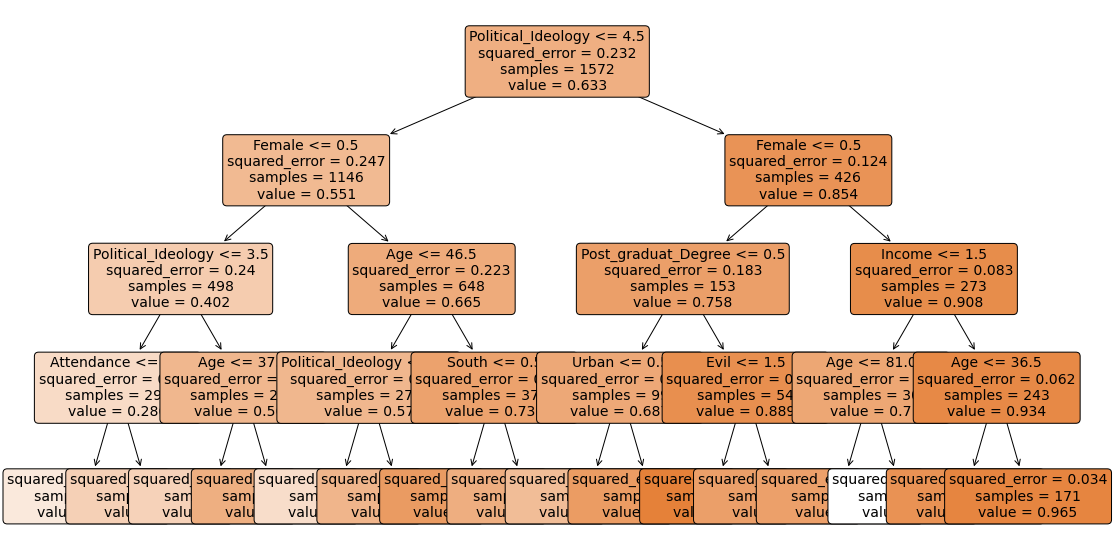

In [3050]:
plt.figure(figsize=(18, 10))
_ = tree.plot_tree(prediction_tree, 
                   feature_names=idependent_plus_dependent.columns[:-1],
                   filled=True, rounded=True, fontsize=14)

In order to look better we use grapgviz to draw the Tree

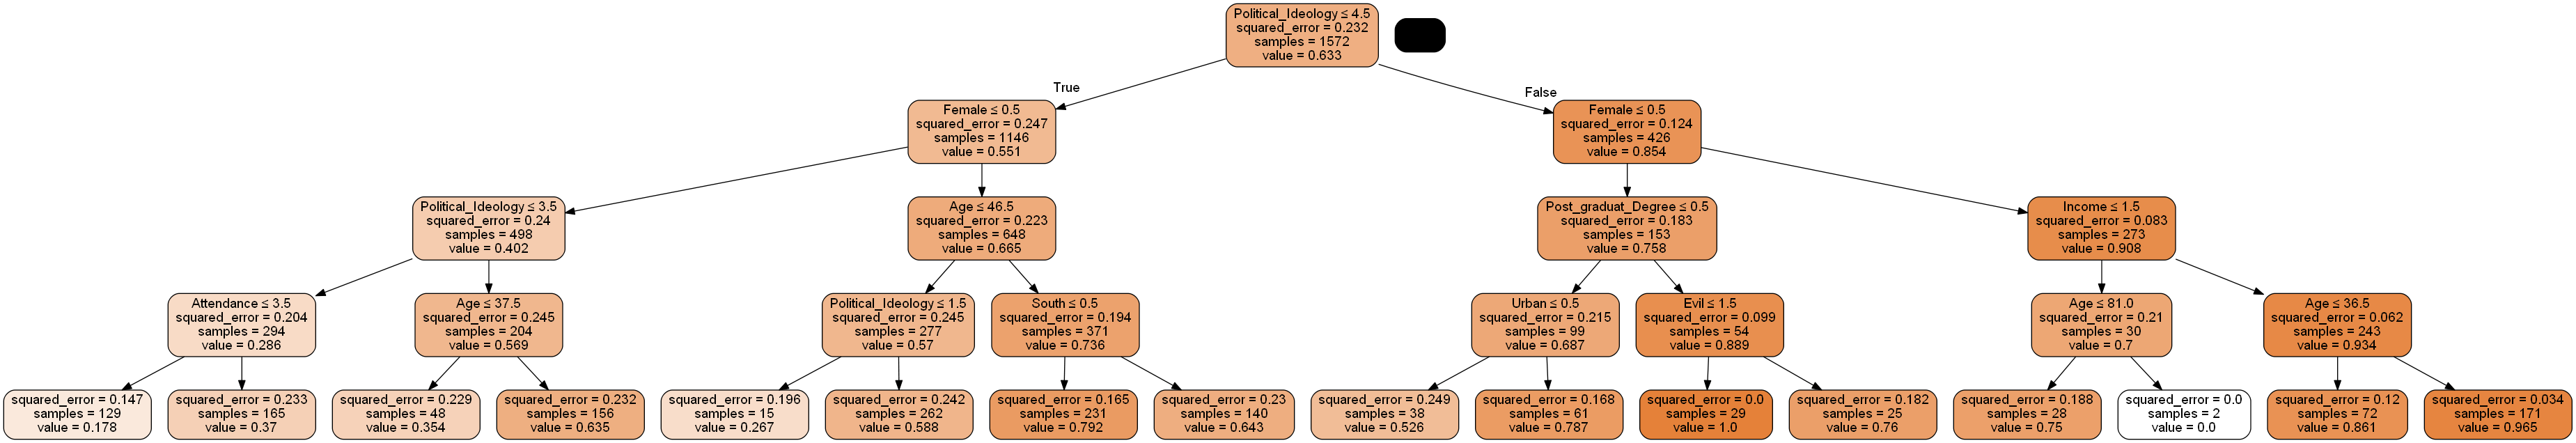

In [3051]:
from io import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(prediction_tree, out_file=dot_data,  
                     feature_names=idependent_plus_dependent.columns[:-1],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())  

Finding the importance of every variable

In [3052]:
prediction_tree.fit(independent, dependent)
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

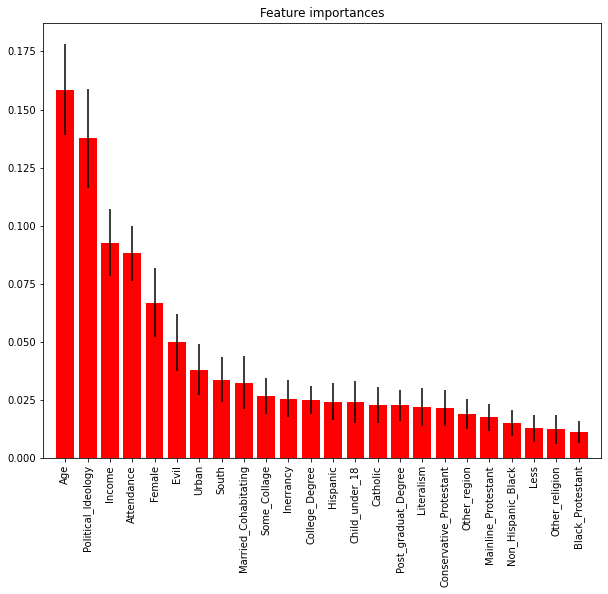

In [3053]:
plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(independent.shape[1]), importances[indices],
        tick_label=[independent.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
plt.xlim([-1, independent.shape[1]])
_ = plt.xticks(rotation=90)

Here we want to know the right depth for the tree

In [3054]:
from sklearn.model_selection import cross_val_score, KFold

from scipy.stats import sem

all_depths = []
all_mean_scores = []

for max_depth in range(1, 11):
    all_depths.append(max_depth)
    simple_tree = DecisionTreeRegressor(max_depth=max_depth)
    cv = KFold(n_splits=5, shuffle=True, random_state=13)
    scores = cross_val_score(simple_tree, independent.values, dependent.values, cv=cv)
    mean_score = np.mean(scores)
    all_mean_scores.append(np.mean(scores))
    print("max_depth = ", max_depth, scores, mean_score, sem(scores))

max_depth =  1 [ 0.06111166  0.05534078 -0.04734183  0.05974445  0.09279398] 0.0443298073988595 0.023867288156190936
max_depth =  2 [0.12308365 0.13278895 0.07461389 0.08616506 0.14840485] 0.11301127929832447 0.014036367982610593
max_depth =  3 [0.14278884 0.16788856 0.08632052 0.11399359 0.1643911 ] 0.1350765247951506 0.015519490414210364
max_depth =  4 [0.15352676 0.13650934 0.10528437 0.13924484 0.15879671] 0.13867240421115468 0.009341858844640996
max_depth =  5 [0.1236972  0.10075889 0.04125741 0.08936302 0.14320422] 0.09965614881272336 0.01730893420888768
max_depth =  6 [ 0.10485155  0.05761642 -0.02311778  0.06418143  0.08031182] 0.05676868949690308 0.021568211883923945
max_depth =  7 [ 0.02334542 -0.1099583  -0.08856901 -0.04396819 -0.05914395] -0.05565880449047791 0.02282761649925477
max_depth =  8 [-0.17033172 -0.13165717 -0.29523656 -0.17977993 -0.11025225] -0.17745152448514112 0.03204862945500679
max_depth =  9 [-0.29582277 -0.18624186 -0.38223233 -0.37788035 -0.21672008] -0

So the best depth is 4 because we can see that the mean_score is maximized in the 4th depth

We can also use `GridSearchCV` to find the right depth

In [3055]:
from sklearn.model_selection import GridSearchCV


parameters = [
  {'max_depth': list(range(1, 11))},
 ]

cv = KFold(n_splits=5, shuffle=True, random_state=13)
clf = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv)

clf = clf.fit(independent.values, dependent.values)
print(clf.best_estimator_)
print(clf.best_params_)

DecisionTreeRegressor(max_depth=4)
{'max_depth': 4}


Here we test the tree to see the scores

In [3056]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(independent, dependent, test_size=0.25)
prediction_tree.fit(X_train, y_train)
prediction_tree.score(X_test, y_test)

0.11129768487646963

Now we are going to run a DecisionTreeClassifier

In [3057]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

Here we draw the Classified tree

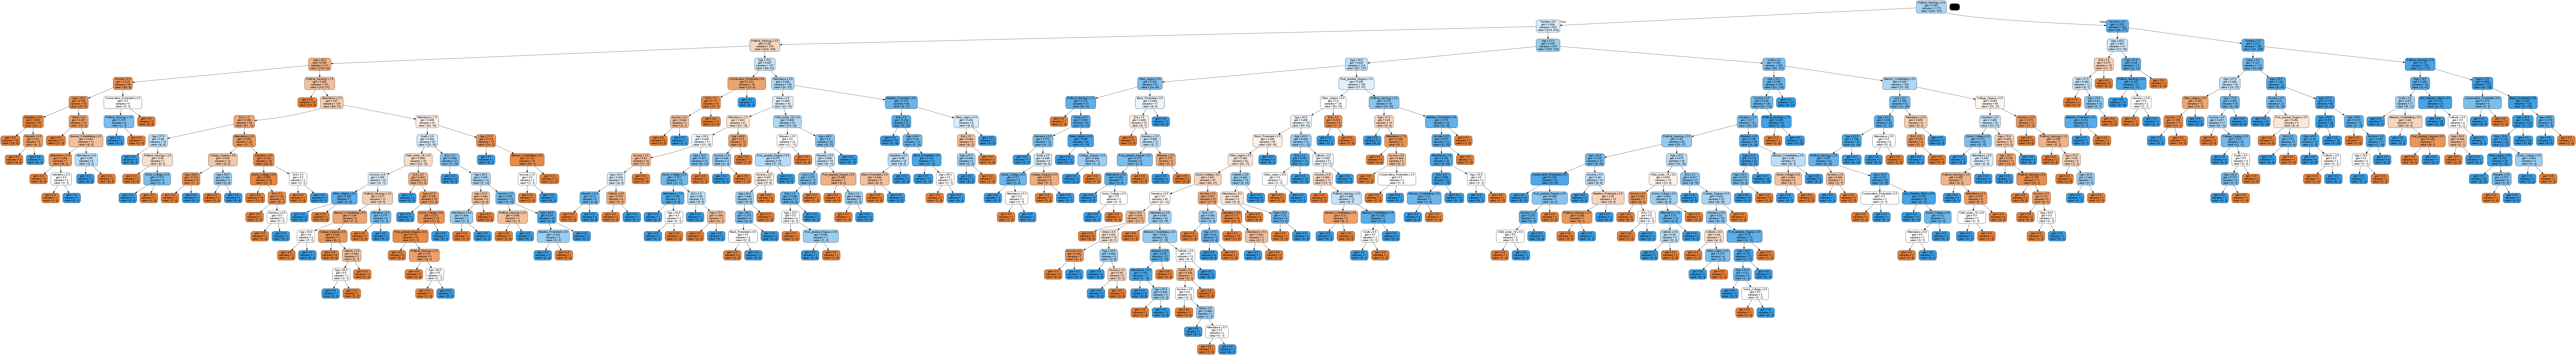

In [3058]:
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                     feature_names=idependent_plus_dependent.columns[:-1],    
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

We will now use entropy as a criterion to create the tree

In [3059]:
clf_entropy = DecisionTreeClassifier(criterion='entropy')
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

Now we will try to test the different trees

First with the gini criterion

In [3060]:
clf_gini = DecisionTreeClassifier(criterion='gini')
clf_gini.fit(X_train, y_train)
gini_predict = clf_gini.predict(X_test)

In [3061]:
from sklearn.metrics import classification_report

print(classification_report(y_test, gini_predict))

              precision    recall  f1-score   support

           0       0.49      0.56      0.52       149
           1       0.71      0.64      0.67       244

    accuracy                           0.61       393
   macro avg       0.60      0.60      0.60       393
weighted avg       0.62      0.61      0.62       393



Now with the entropy as a critirion

In [3062]:
entropy_predict = clf_entropy.predict(X_test)
print(classification_report(y_test, entropy_predict))

              precision    recall  f1-score   support

           0       0.53      0.57      0.55       149
           1       0.73      0.69      0.71       244

    accuracy                           0.65       393
   macro avg       0.63      0.63      0.63       393
weighted avg       0.65      0.65      0.65       393



We can see the scores for the DecisionTreeClassifier tree

In [3063]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from scipy.stats import sem

cv_score = cross_val_score(clf, 
                            X_test, y_test, cv=10,
                           scoring='accuracy')

print(np.mean(cv_score), sem(cv_score))


0.5774358974358974 0.025365650920514043


We can see that the scores are much better that before.

We continue with the `BaggingClassifier`.

In [3064]:
from sklearn.ensemble import BaggingClassifier

bagging_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini'),
                                       n_estimators=50, 
                                       n_jobs=-1)
bagged_cv_score = cross_val_score(bagging_tree, 
                                   X_test, y_test,
                                  cv=3, scoring='accuracy')

print(np.mean(bagged_cv_score), sem(bagged_cv_score))

0.6463104325699746 0.006732191631207622


We can see that the BaggingClassifier method puts out a better result score than the DecisionTreeClassifier method

### Now we will try to create Random Forests

In [3065]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=50, max_depth=None,
                                min_samples_split=2)
forest.fit(X_train, y_train)
scores = cross_val_score(forest, X_test, y_test, cv=10)
scores.mean()

0.6614102564102564

In [3066]:
from sklearn.metrics import mean_absolute_error

preds = forest.predict(X_test)
mean_absolute_error(y_test, preds)

0.3053435114503817

### Here we try Extremely randomized trees

In [3067]:
from sklearn.ensemble import ExtraTreesClassifier

extremely_rts = ExtraTreesClassifier(n_estimators=50, 
                                     max_depth=None,
                                     min_samples_split=2)
extremely_rts.fit(X_train, y_train)
scores = cross_val_score(forest, X_test, y_test, cv=10)
scores.mean() 

0.6384615384615385

Finding the importance of every variable

In [3068]:
forest.fit(independent, dependent)
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

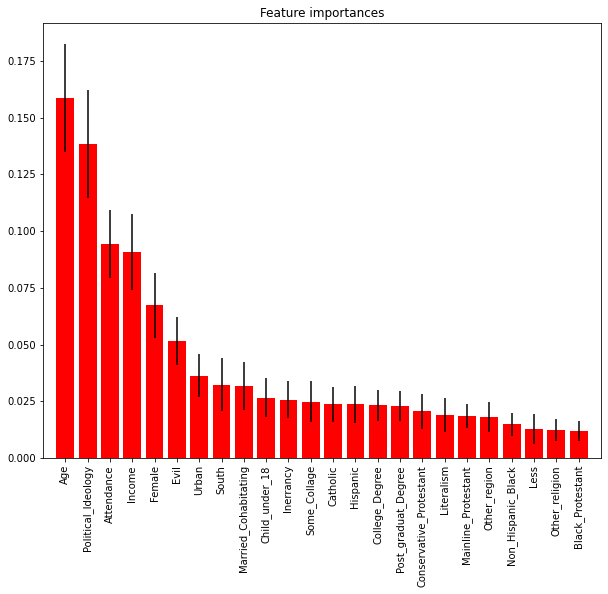

In [3069]:
plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(independent.shape[1]), importances[indices],
        tick_label=[independent.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
plt.xlim([-1, independent.shape[1]])
_ = plt.xticks(rotation=90)

### Trying the Boosting method

In [3070]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(max_depth=4)
rgr = AdaBoostRegressor(clf, n_estimators=5000)

In [3071]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(independent, dependent)
rgr.fit(X_train, y_train)
rgr.score(X_test, y_test)


0.08144303631961924

Finding the MAE

In [3072]:
predicted = rgr.predict(X_test)
mean_absolute_error(predicted, y_test)

0.4334349909780387

Finding importance of each variable

In [3073]:
rgr.fit(independent, dependent)

importances = rgr.feature_importances_

std = np.std([tree.feature_importances_ for tree in rgr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

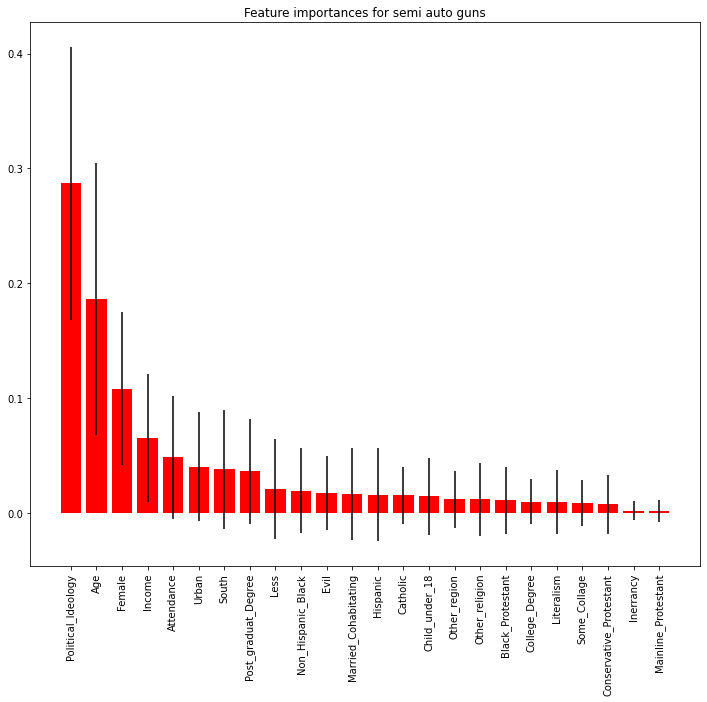

In [3074]:
plt.figure(figsize=(12, 10))
plt.title("Feature importances for semi auto guns")
plt.bar(range(independent.shape[1]), importances[indices],
        tick_label=[independent.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
_ = plt.xticks(rotation=90)
plt.show()

Using the `XGBRegressor` method

In [3075]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [3076]:
preds = xgb_reg.predict(X_test)
mean_absolute_error(y_test, preds)

0.41140107909553986

In [3077]:

scores = -cross_val_score(rgr, X_test, y_test, cv=10, 
                          scoring="neg_mean_absolute_error")
print(scores.mean())

0.49146200984532096


We can see that the score is worst than the forest one

### We will now try the LightGBM method

In [3078]:
import lightgbm as lgb

lgb_reg = lgb.LGBMRegressor()

In [3079]:
lgb_reg.fit(X_train, y_train)
preds = lgb_reg.predict(X_test)

In [3080]:
mean_absolute_error(y_test, preds)

0.3900156503321792

Cross Validation

In [3081]:
scores = cross_val_score(lgb_reg, 
                         X_test, y_test,
                         scoring="neg_mean_absolute_error", cv=10)
print(np.mean(-scores))

0.4110055780028391


### Voting Ensembles method

In [3082]:
from sklearn.ensemble import VotingRegressor

xgb_reg = xgb.XGBRegressor()
lgb_reg = lgb.LGBMRegressor()
vreg = VotingRegressor(estimators=[('xgb', xgb_reg), 
                                   ('lgb', lgb_reg)],
                       n_jobs=-1)
                       
scores = cross_val_score(vreg, X_test, y_test,
                         cv=5, scoring='neg_median_absolute_error', n_jobs=-1)
print(np.mean(-scores))

0.4079752582279882


## Stacked Ensembles

In [3083]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

xgb_reg = xgb.XGBRegressor()
lgb_reg = lgb.LGBMRegressor()

estimators = [('xgb', xgb_reg), ('lgb', lgb_reg)]
final_estimator = LinearRegression()

sreg = StackingRegressor(estimators=estimators, final_estimator=final_estimator, n_jobs=-1)

scores = cross_val_score(sreg, X_test, y_test,
                         cv=5, scoring='neg_median_absolute_error', n_jobs=-1)
print(np.mean(-scores))

0.42909120810673607


### After testing all the trees we conclude that the forest tree is the best for our example

Creating testing and trainng data for each dependent variable

In [3084]:
X_train_cap, X_test_cap, y_train_cap, y_test_cap = train_test_split(independent, useful_vars['High_cap'], test_size=0.25)
X_train_hand, X_test_hand, y_train_hand, y_test_hand = train_test_split(independent, useful_vars['Handguns'], test_size=0.25)
X_train_con, X_test_con, y_train_con, y_test_con = train_test_split(independent, useful_vars['Concealed'], test_size=0.25)
X_train_scho, X_test_scho, y_train_scho, y_test_scho = train_test_split(independent, useful_vars['Armed_schools'], test_size=0.25)
X_train_teach, X_test_teach, y_train_teach, y_test_teach = train_test_split(independent, useful_vars['Armed_teachers'], test_size=0.25)
X_train_safe, X_test_safe, y_train_safe, y_test_safe = train_test_split(independent, useful_vars['Safety_prog'], test_size=0.25)
X_train_men, X_test_men, y_train_men, y_test_men = train_test_split(independent, useful_vars['Mental_Health_Screening'], test_size=0.25)

Creating the Trees for each variable

In [3085]:
forest_high_cap = RandomForestClassifier(n_estimators=50, max_depth=None,
                                min_samples_split=2)
forest_high_cap.fit(X_train_cap, y_train_cap)
forest_hand = RandomForestClassifier(n_estimators=50, max_depth=None,
                                min_samples_split=2)
forest_hand.fit(X_train_hand, y_train_hand)
forest_con = RandomForestClassifier(n_estimators=50, max_depth=None,
                                min_samples_split=2)
forest_con.fit(X_train_con, y_train_con)
forest_scho = RandomForestClassifier(n_estimators=50, max_depth=None,
                                min_samples_split=2)
forest_scho.fit(X_train_scho, y_train_scho)
forest_teach = RandomForestClassifier(n_estimators=50, max_depth=None,
                                min_samples_split=2)
forest_teach.fit(X_train_teach, y_train_teach)
forest_safe = RandomForestClassifier(n_estimators=50, max_depth=None,
                                min_samples_split=2)
forest_safe.fit(X_train_safe, y_train_safe)
forest_men = RandomForestClassifier(n_estimators=50, max_depth=None,
                                min_samples_split=2)
forest_men.fit(X_train_men, y_train_men)


RandomForestClassifier(n_estimators=50)

Here I run a prediction for the tree with the High capacity belief variable

In [3086]:
preds = forest_high_cap.predict(X_test_cap)
mean_absolute_error(y_test_cap, preds)

0.24173027989821882

Finding importance for each variable

In [3087]:
importances = forest_high_cap.feature_importances_

std = np.std([tree.feature_importances_ for tree in rgr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

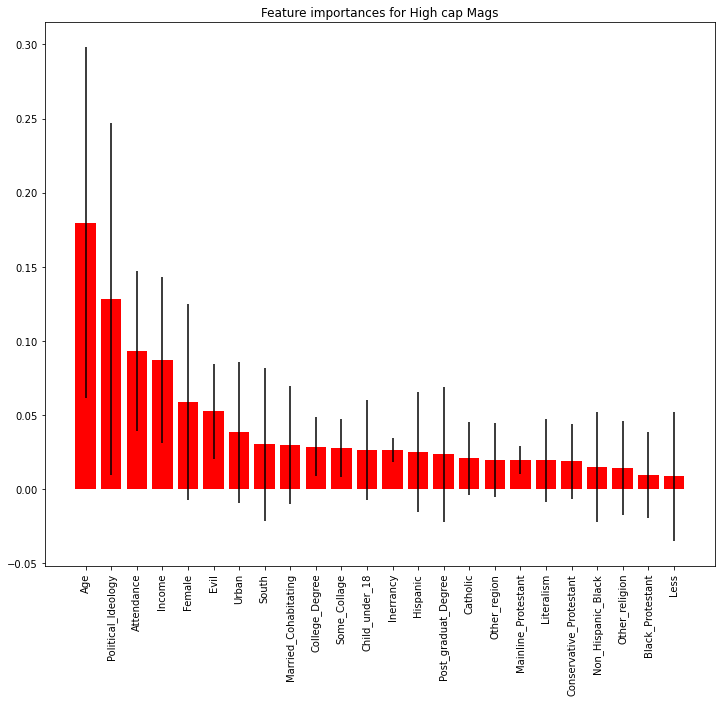

In [3088]:
plt.figure(figsize=(12, 10))
plt.title("Feature importances for High cap Mags")
plt.bar(range(X_train_cap.shape[1]), importances[indices],
        tick_label=[X_train_cap.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
_ = plt.xticks(rotation=90)
plt.show()

In [3089]:
importances = forest_hand.feature_importances_

std = np.std([tree.feature_importances_ for tree in rgr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

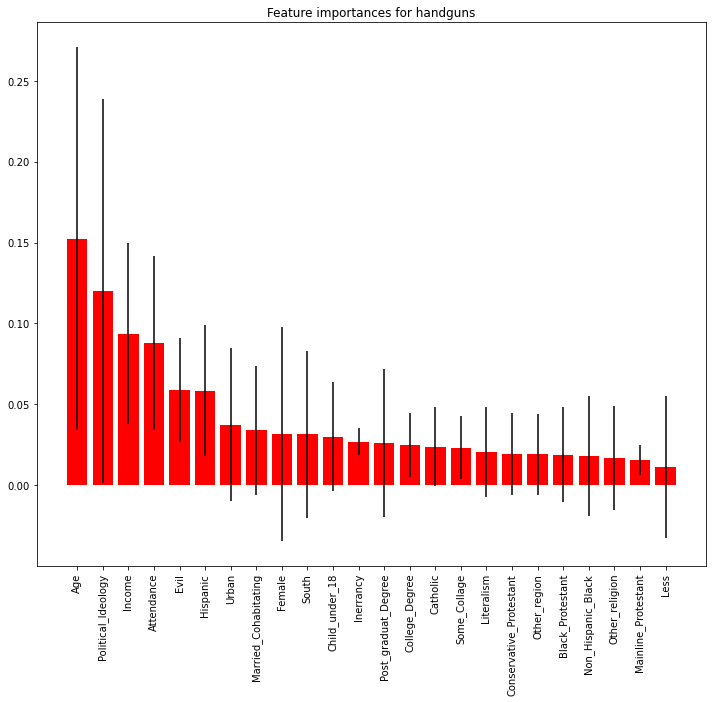

In [3090]:
plt.figure(figsize=(12, 10))
plt.title("Feature importances for handguns")
plt.bar(range(X_train_hand.shape[1]), importances[indices],
        tick_label=[X_train_hand.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
_ = plt.xticks(rotation=90)
plt.show()

In [3091]:
importances = forest_con.feature_importances_

std = np.std([tree.feature_importances_ for tree in rgr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

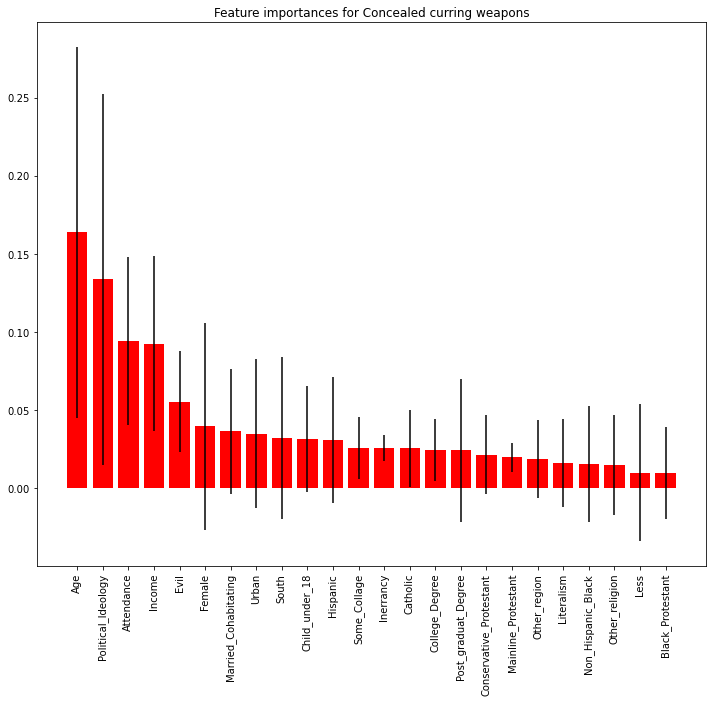

In [3092]:
plt.figure(figsize=(12, 10))
plt.title("Feature importances for Concealed curring weapons")
plt.bar(range(X_train_con.shape[1]), importances[indices],
        tick_label=[X_train_con.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
_ = plt.xticks(rotation=90)
plt.show()

In [3093]:
importances = forest_scho.feature_importances_

std = np.std([tree.feature_importances_ for tree in rgr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

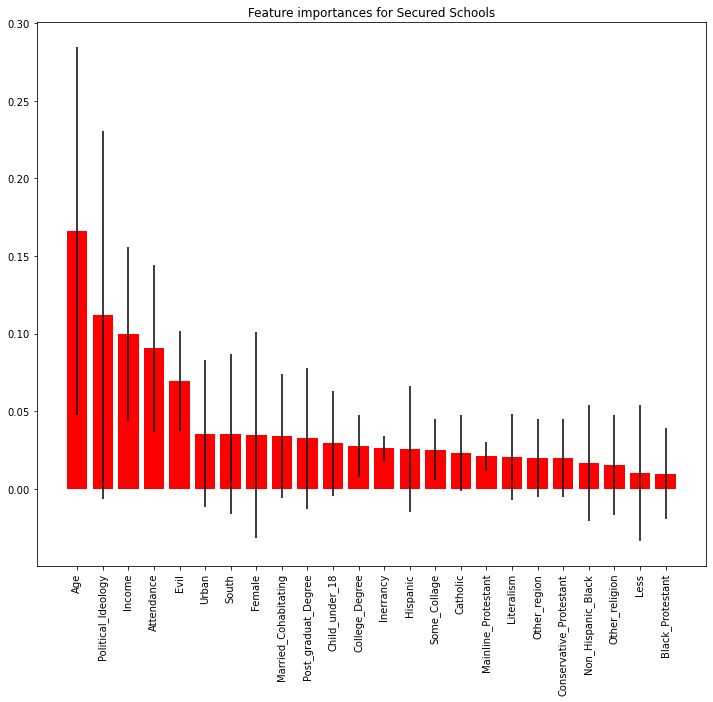

In [3094]:
plt.figure(figsize=(12, 10))
plt.title("Feature importances for Secured Schools")
plt.bar(range(X_train_scho.shape[1]), importances[indices],
        tick_label=[X_train_scho.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
_ = plt.xticks(rotation=90)
plt.show()

In [3095]:
importances = forest_teach.feature_importances_

std = np.std([tree.feature_importances_ for tree in rgr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

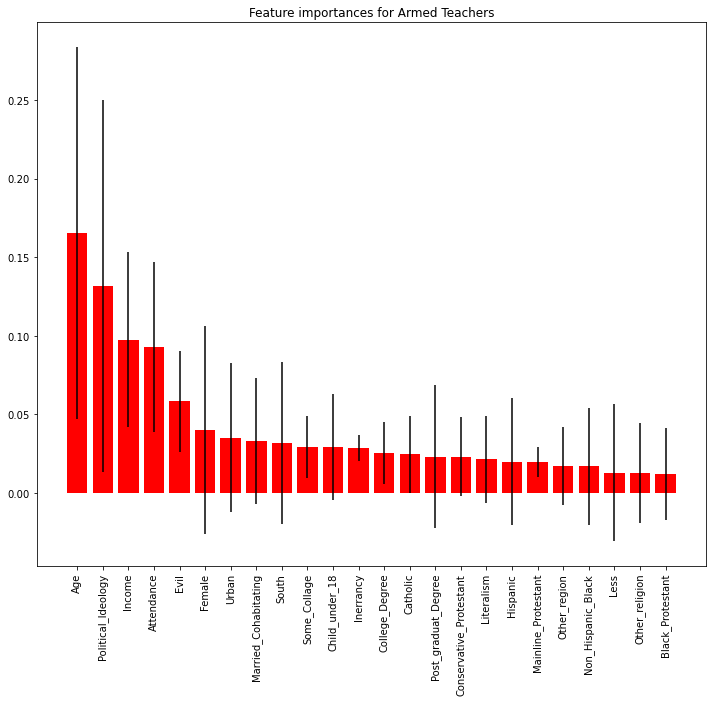

In [3096]:
plt.figure(figsize=(12, 10))
plt.title("Feature importances for Armed Teachers")
plt.bar(range(X_train_teach.shape[1]), importances[indices],
        tick_label=[X_train_teach.columns[x] for x in indices],
        color="r", yerr=std[indices], align="center")
_ = plt.xticks(rotation=90)
plt.show()

We can see from the graphs that the the variable evil, which measures on what level the respondent believes in supernatural evil, is 6th in importance for the trees for semi_auto views, handgun views and High capacity ammo views. So it makes a strong showing in the models. The most important factor is the age, after that the Political Ideology and after that the income of of the respondent. And the less important factor is the one which shows if the respondent has an education less than high school and the one that shows if the respondent is Black and Protestand.